In [1]:
import os
import json
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from recsys.models import WD
from recsys.data.movielens import MovielensDataset
from recsys.utils.metrics import evaluate
from recsys.utils import recommender, visualizer

In [2]:
with open("movielens/processed/num_sparse_features.json", "r") as f:
    num_sparse_features = json.load(f)
    
with open("movielens/processed/dense_features.json", "r") as f:
    dense_features = json.load(f)
    
with open("movielens/processed/experiment_group.json", "r") as f:
    experiment_group = json.load(f)
experiment_group[WD.model_name] = []

train = pd.read_parquet("movielens/processed/train.parquet")
test = pd.read_parquet("movielens/processed/test.parquet")

In [3]:
# Training Hyperparameter
batch_size = 64
latent_dim = 16
hidden_layers = [32, 32, 32]
lr = 1e-3
epochs = 10
cross_features = [["gender", "genre"], ["gender", "occupation"]]

# Define Dataset
train_ds = MovielensDataset(train, list(num_sparse_features.keys()), dense_features)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

test_ds = MovielensDataset(test, list(num_sparse_features.keys()), dense_features)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=test["item_id"].nunique(), shuffle=False)

device = torch.device("cpu")
model = WD(num_sparse_features, dense_features, latent_dim, hidden_layers, cross_features)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model)

WideAndDeep(
  (deep): Deep(
    (sparse_arch): ModuleDict(
      (user_id): Embedding(943, 16)
      (item_id): Embedding(1682, 16)
      (gender): Embedding(2, 16)
      (occupation): Embedding(21, 16)
      (genre): Embedding(19, 16)
    )
    (dense_arch): Linear(in_features=1, out_features=16, bias=False)
    (mlp): Sequential(
      (0): Linear(in_features=96, out_features=32, bias=False)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=False)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=32, bias=False)
      (5): ReLU()
      (6): Linear(in_features=32, out_features=1, bias=False)
    )
  )
  (wide): Wide(
    (sparse_arch): ModuleDict(
      (user_id): Embedding(943, 1)
      (item_id): Embedding(1682, 1)
      (gender): Embedding(2, 1)
      (occupation): Embedding(21, 1)
      (genre): Embedding(19, 1)
      (cross_gender_genre): Embedding(38, 1)
      (cross_gender_occupation): Embedding(42, 1)
    )
    (dense_arch): Linear(in_fe

Epoch 1/10: 100%|█| 5747/5747 [00:14<00:00, 394.73it/s, auc=0.0000, logloss=0.42
Epoch 2/10: 100%|█| 5747/5747 [00:14<00:00, 388.25it/s, auc=0.7086, logloss=0.38
Epoch 3/10: 100%|█| 5747/5747 [00:16<00:00, 355.72it/s, auc=0.8199, logloss=0.35
Epoch 4/10: 100%|█| 5747/5747 [00:17<00:00, 321.37it/s, auc=0.8272, logloss=0.40
Epoch 5/10: 100%|█| 5747/5747 [00:19<00:00, 294.72it/s, auc=0.8312, logloss=0.45
Epoch 6/10: 100%|█| 5747/5747 [00:20<00:00, 283.73it/s, auc=0.8353, logloss=0.27
Epoch 7/10: 100%|█| 5747/5747 [00:20<00:00, 279.24it/s, auc=0.8396, logloss=0.53
Epoch 8/10: 100%|█| 5747/5747 [00:20<00:00, 276.29it/s, auc=0.8448, logloss=0.24
Epoch 9/10: 100%|█| 5747/5747 [00:19<00:00, 289.70it/s, auc=0.8511, logloss=0.24
Epoch 10/10: 100%|█| 5747/5747 [00:18<00:00, 305.78it/s, auc=0.8581, logloss=0.2


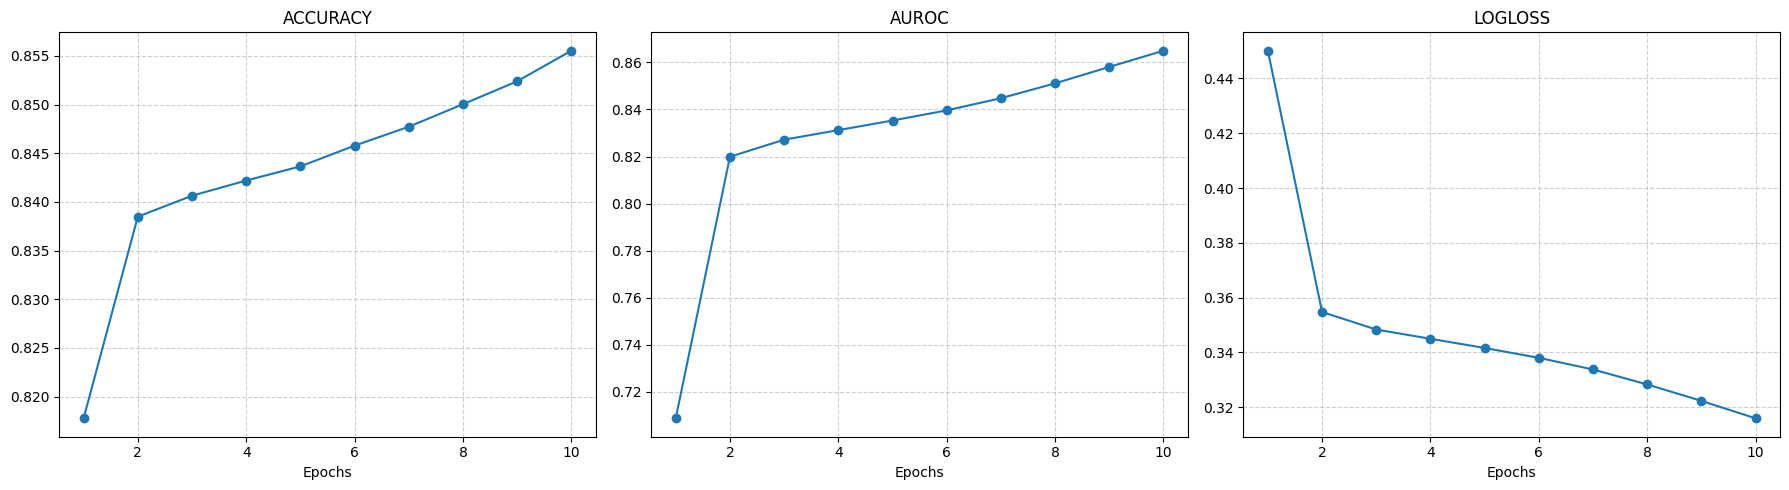

In [4]:
history = recommender.train(model, train_loader, optimizer, device, epochs)
visualizer.plot_history(history)

Recommend (wd): 100%|████████████| 943/943 [00:10<00:00, 93.85it/s, user_id=942]


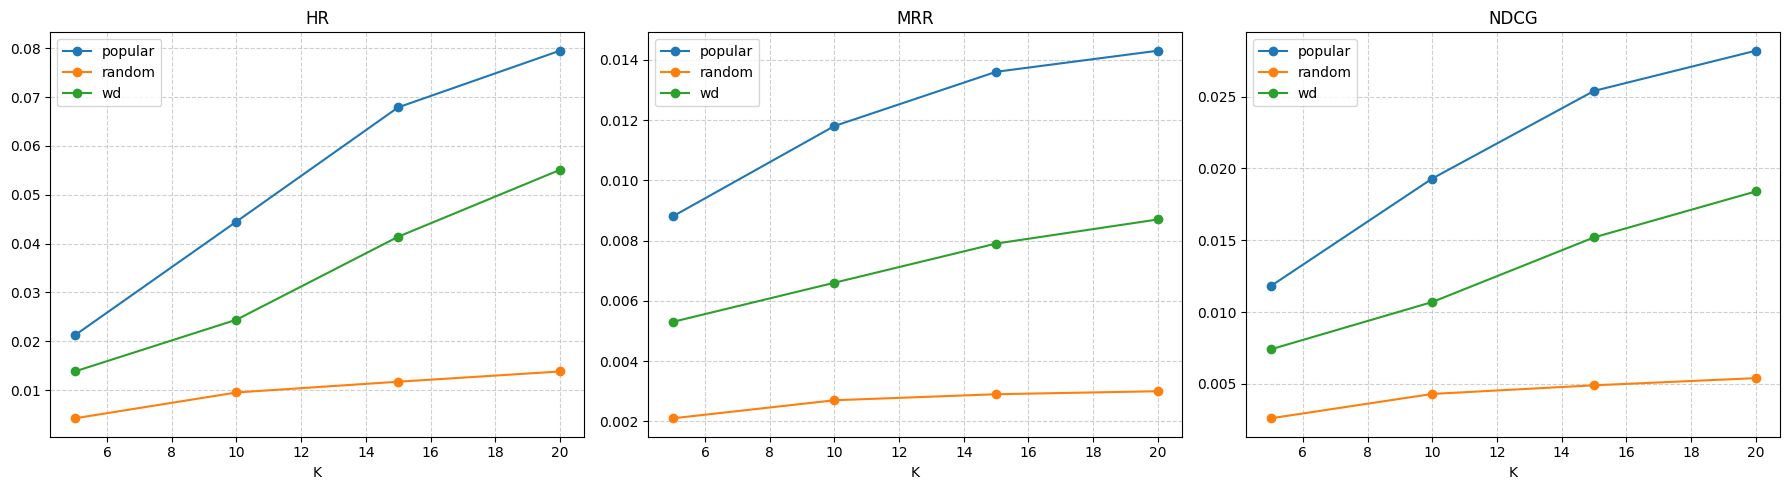

In [5]:
user_recommendations = recommender.inference(model, device, test_loader)

ks = [5, 10, 15, 20]
_test = test[test["rating"]==1]
recommendations = {
    "popular": np.array(experiment_group["popular"]),
    "random": np.array(experiment_group["random"]),
    model.model_name: user_recommendations
}
results = evaluate(_test, recommendations, ks)
visualizer.plot_metrics(results)